<a href="https://colab.research.google.com/github/karnigili/NetworksNeuroscience/blob/master/rs_fmri_networks_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction using ICA from resting state networks  

This notebook includes code that imports a preprocessed fMRI image and demonstrates various ways to extract features

First let's import the relevant libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import json

## Data collection and inspection

### Nifti headers 

In [0]:
import nibabel as nib

def load_image(path):
    # load an img file
    return nib.load(path)

def get_TR(img):
    # retrieve TR data
    return img.header.get_zooms()[-1]

def get_slices(img):
    # retrieve number of slices
    return img.shape[2]
  
def get_header(img):
    # print the full header
    return(img.header)


In [0]:
path='sub-10228_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'


img = load_image(path)
TR = get_TR(img)
slices = get_slices(img)

    
print('TR: {}'.format(TR))
print('# of slices: {}'.format(slices))

TR: 2.0
# of slices: 49


In [0]:
header=get_header(img)
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  65  77  49 152   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 3. 3. 4. 2. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1686.6385
cal_min         : -170.19273
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v0.10.4+3.g0aaf'
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -96.0
qoffset_y   

## Feature exctraction

In [0]:
from nilearn import input_data
from nilearn import datasets
from nilearn import plotting
from nilearn.plotting import plot_prob_atlas, plot_roi, plot_matrix

from nilearn.decomposition import CanICA 
from nilearn import image
from nilearn.regions import RegionExtractor


from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')


/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
## craete masker based on the atlas 
## and create a time series of the uploaded image using the masker
def create_mask(atlas_img, fmri_img):
  # generates a mask given img and atlas
  masker=NiftiLabelsMasker(labels_img=atlas_img, standardize=True)
  time_series=masker.fit_transform(fmri_img)
  
  return time_series

# using the correlation measures defined above, 
# we calculate the correaltion matrixes
def calc_correlation_matrix(time_series):
  # given a time series, return a correlation matrix
  # we regress out the confounds (as found in the 
  # preprocessing stage)
  return correlation_measure.fit_transform([time_series])[0]

#and we plot,
def plot_cor_matrix(correlation_matrix, title, labels=None):
  ## plot the correlation matrix
  
    
  np.fill_diagonal(correlation_matrix, 0)
  if labels:
    plot_matrix(correlation_matrix, figure=(10, 8), 
              labels=labels,
                       vmax=0.8, vmin=-0.8, reorder=True)
  else:
    plot_matrix(correlation_matrix, figure=(10, 8), 
              labels=range(correlation_matrix.shape[1]),
                       vmax=0.8, vmin=-0.8, reorder=True)
  plt.title(title)
  plt.show()




### SCA analysis  ()

I include two types of atlases. The first is the Harvard-Oxford probabilistic atlas (Makris et al., 2006; Frazier et al., 2005; Desikan et al., 2006; Goldstein et al., 2007) and the second is Smith's ICA functional map (Smith et al., 2009).

The Harvard-Oxford atals is based on MNI defined regions and the Smith's atlas reflecs regions resulting from an ndependent analyses of resting and activation brain dynamics.

Smith's includes 10 resting-state networks (rsns)

In [0]:
## import an existing map

# Harvard-Oxford
'''
retirived from https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases
'''
harvard_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
harvard_maps = harvard_dataset.maps
harvard_labels = harvard_dataset.labels




In [0]:
## Smith

smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn10


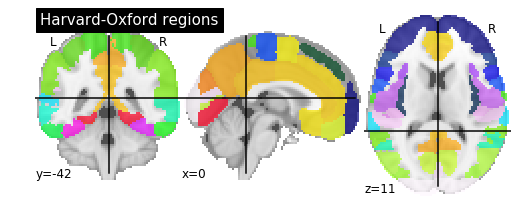

In [0]:
# plot the ROIs based on the map chosen
plot_roi(harvard_maps, title='Harvard-Oxford regions')

In [0]:
extraction = RegionExtractor(smith_atlas_rs_networks, min_region_size=800,
                             threshold=98, thresholding_strategy='percentile')

# Just call fit() to execute region extraction procedure
extraction.fit()
smith_maps = extraction.regions_img_


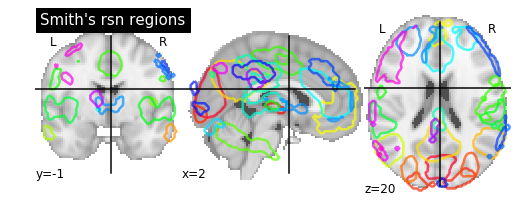

In [0]:
plotting.plot_prob_atlas(smith_maps, title="Smith's rsn regions")

In [0]:
# An example for correlation matrix using both atlases


# Smith
# We take the first out of the 10 rsns
smith_1st_rsn=image.index_img(smith_atlas_rs_networks, 0)

In [0]:
smith_time_series=create_mask(smith_1st_rsn, img)


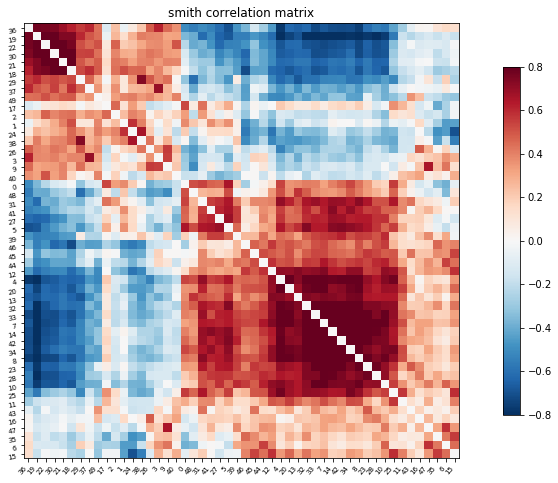

In [0]:


smith_time_series=create_mask(smith_1st_rsn, img)
cropped_smith_time_series=np.array([e[:50] for e in smith_time_series])
smith_cor_matrix=calc_correlation_matrix(cropped_smith_time_series)
plot_cor_matrix(smith_cor_matrix, 'smith correlation matrix')




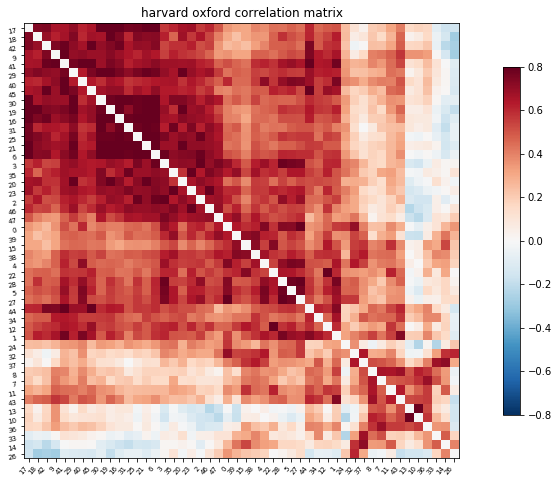

In [0]:
## plot the correlation matrix
# Harvard Oxford
harvard_oxford_time_series=create_mask(harvard_maps, img)
harvard_oxford_cor_matrix=calc_correlation_matrix(harvard_oxford_time_series)
plot_cor_matrix(harvard_oxford_cor_matrix, 'harvard oxford correlation matrix')

### ICA analysis  (Varoquaux et al., 2010)


In [0]:
# perform an ICA given the subset of the data. 
ica = CanICA(n_components=20,
                random_state=0)

ica.fit(img)           

CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
       mask_args=None, mask_strategy='epi', memory=Memory(location=None),
       memory_level=0, n_components=20, n_init=10, n_jobs=1, random_state=0,
       smoothing_fwhm=6, standardize=True, t_r=None, target_affine=None,
       target_shape=None, threshold='auto', verbose=0)

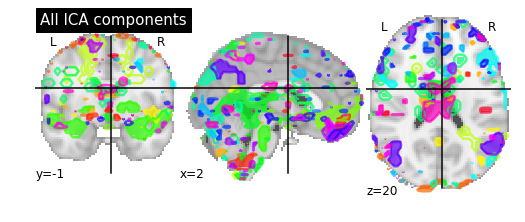

In [0]:
# exctract a 3D representation of the componenets and plot
components_img=ica.components_img_
plot_prob_atlas(components_img, title='All ICA components')
plt.show()

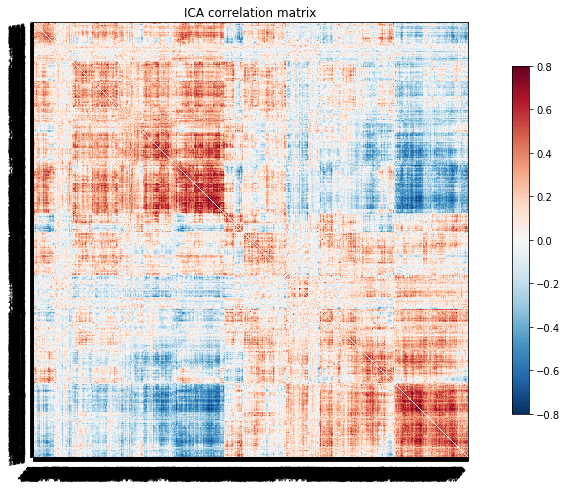

In [0]:
# ICA
components_img_1st=image.index_img(components_img, 0)
ica_time_series=create_mask(components_img_1st, img)
ica_cor_matrix=calc_correlation_matrix(ica_time_series)
plot_cor_matrix(ica_cor_matrix, 'ICA correlation matrix')



SZ teaser

In [0]:
path_sz='sub-50006_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
img_sz= load_image(path_sz)


In [0]:
# ica SZ (same componenets as control)

components_img_sz_1st=image.index_img(components_img_sz, 0)
ica_sz_time_series=create_mask(components_img_sz_1st, img_sz)
ica_sz_cor_matrix=calc_correlation_matrix(ica_sz_time_series)
plot_cor_matrix(ica_sz_cor_matrix, 'ICA correlation matrix- SZ')



In [0]:
# ica control vs SZ (same componenets as control)

p_correlation_measure = ConnectivityMeasure(kind='partial_correlation')


components_img_sz_1st=image.index_img(components_img_sz, 0)
ica_sz_time_series=create_mask(components_img_sz_1st, img_sz)
ica_sz_cor_matrix=calc_correlation_matrix(ica_sz_time_series)
diff_cor_mtarix = ica_cor_matrix-ica_sz_cor_matrix

plot_cor_matrix(diff_cor_mtarix, 'ICA correlation matrix- control- SZ')



Varoquaux G. et al. “A group model for stable multi-subject ICA on fMRI datasets”, NeuroImage Vol 51 (2010), p. 288-299


Makris N, Goldstein JM, Kennedy D, Hodge SM, Caviness VS, Faraone SV, Tsuang MT, Seidman LJ. Decreased volume of left and total anterior insular lobule in schizophrenia. Schizophr Res. 2006 Apr;83(2-3):155-71


Frazier JA, Chiu S, Breeze JL, Makris N, Lange N, Kennedy DN, Herbert MR, Bent EK, Koneru VK, Dieterich ME, Hodge SM, Rauch SL, Grant PE, Cohen BM, Seidman LJ, Caviness VS, Biederman J. Structural brain magnetic resonance imaging of limbic and thalamic volumes in pediatric bipolar disorder. Am J Psychiatry. 2005 Jul;162(7):1256-65


Desikan RS, Ségonne F, Fischl B, Quinn BT, Dickerson BC, Blacker D, Buckner RL, Dale AM, Maguire RP, Hyman BT, Albert MS, Killiany RJ. An automated labeling system for subdividing the human cerebral cortex on MRI scans into gyral based regions of interest. Neuroimage. 2006 Jul 1;31(3):968-80.


Goldstein JM, Seidman LJ, Makris N, Ahern T, O'Brien LM, Caviness VS Jr, Kennedy DN, Faraone SV, Tsuang MT. Hypothalamic abnormalities in schizophrenia: sex effects and genetic vulnerability. Biol Psychiatry. 2007 Apr 15;61(8):935-45


Smith SM, Fox PT, Miller KL, Glahn DC, Fox PM, Mackay CE, 
Filippini N, Watkins KE, Toro R, Laird AR, and Beckmann CF. 2009. 
Correspondence of the brain’s functional architecture during activation and rest. 
Proc Natl Acad Sci USA (PNAS), 106(31):13040-13045.
